In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from PIL import Image 
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50V2, InceptionV3, Xception, ResNet50, ResNet152V2
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout

K.clear_session()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataset='/content/drive/MyDrive/Bangkit/Project/Food_V2/'

train_folder = os.path.join(dataset,"Train")
test_folder = os.path.join(dataset,"Test")
validation_folder = os.path.join(dataset,"Valid")

In [3]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))
 
count_files(os.path.join(test_folder))

There are 130 files in French fries
There are 230 files in Hotdog
There are 230 files in Donut
There are 230 files in Sandwich
There are 130 files in Taco
There are 130 files in Fried chicken
There are 230 files in Pizza
There are 230 files in Burger
There are 130 files in Baked Potato


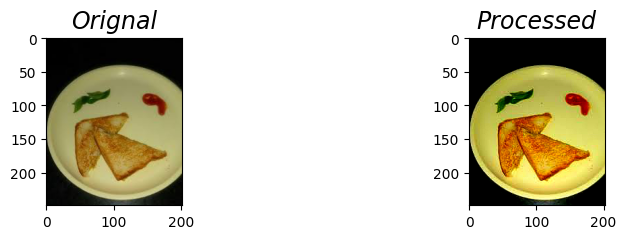

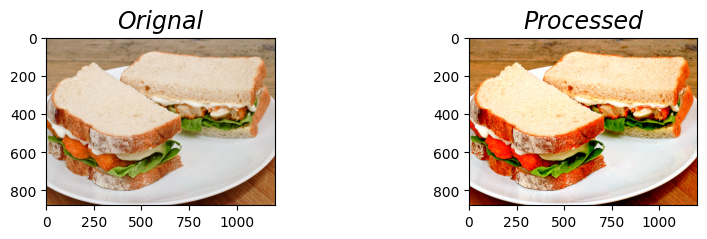

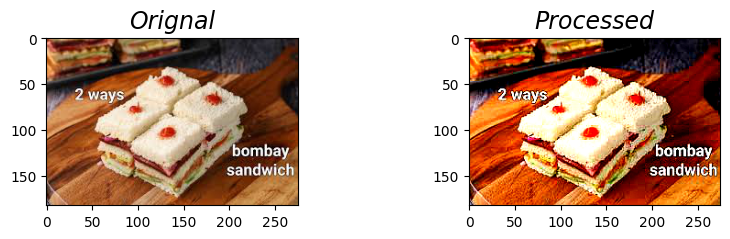

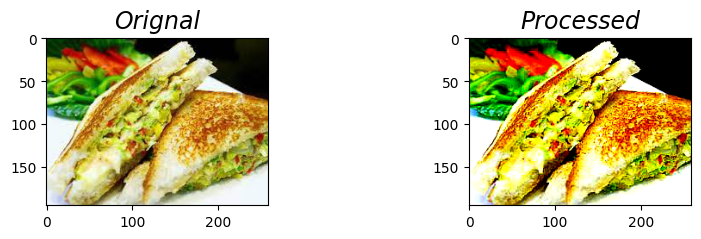

In [4]:
image_folder="Sandwich"  
number_of_images=4   

def Preprocess():
    j=1
    for i in range(number_of_images):
    
        folder = os.path.join(test_folder,image_folder)
        a=random.choice(os.listdir(folder))

        image=Image.open(os.path.join(folder,a))
        image_duplicate=image.copy()
        plt.figure(figsize=(10,10))

        plt.subplot(number_of_images,2,j)
        plt.title(label='Orignal', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image)
        j+=1

        image1=ImageEnhance.Color(image_duplicate).enhance(1.35)
        image1=ImageEnhance.Contrast(image1).enhance(1.45)
        image1=ImageEnhance.Sharpness(image1).enhance(2.5)
        
        plt.subplot(number_of_images,2,j)
        plt.title(label='Processed', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image1)
        j+=1
        
Preprocess()

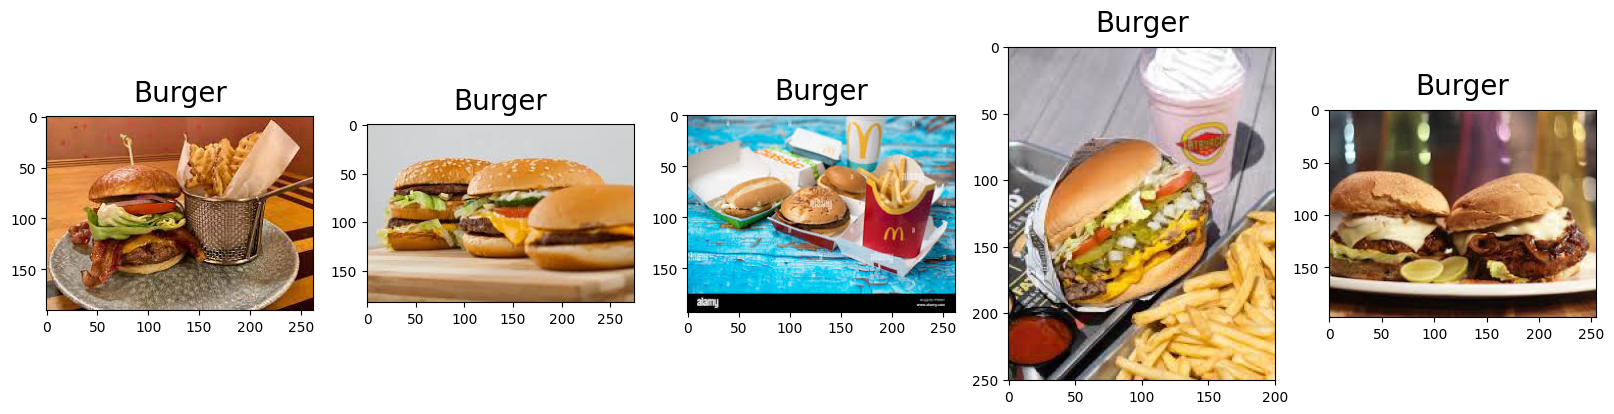

In [5]:
select_food="Burger"
rows,columns = 1,5

display_folder=os.path.join(train_folder,select_food)
total_images=rows*columns
fig=plt.figure(1, figsize=(20, 10))

for i,j in enumerate(os.listdir(display_folder)):      
    
    img = plt.imread(os.path.join(train_folder,select_food,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_food, pad = 11, size=20)
    plt.imshow(img)
    
    if i==total_images-1:
        break

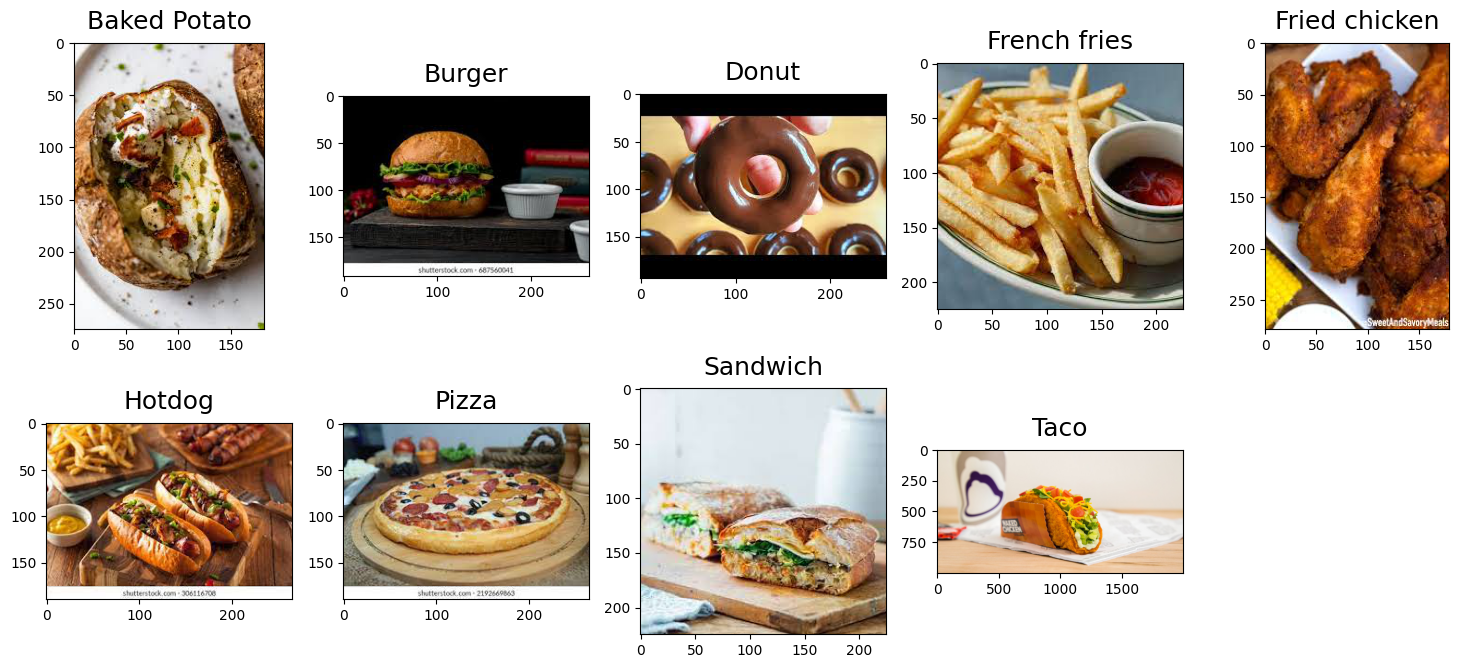

In [6]:
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder,food_folder,food_selected))
                                     
fig=plt.figure(1, figsize=(15, 10))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(3, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    
plt.tight_layout()

In [7]:
image_size = [224, 224]
num_classes = 9

pretrained_resnet_model = tf.keras.applications.ResNet50V2(weights='imagenet',
                         include_top=False,
                         input_tensor = (tf.keras.layers.Input(shape=(image_size + [3])))
                         )
pretrained_resnet_model.trainable=False
model = tf.keras.Sequential([
    pretrained_resnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=num_classes, activation='softmax')
])

94668760/94668760 [==============================] - 0s 0us/step


In [8]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [9]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         rotation_range = 30,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224, 224),
    batch_size = 64,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (224, 224),
    batch_size = 64, 
    class_mode = 'categorical')

Found 9757 images belonging to 9 classes.
Found 1670 images belonging to 9 classes.


In [10]:
class_map = training_set.class_indices
class_map

{'Baked Potato': 0,
 'Burger': 1,
 'Donut': 2,
 'French fries': 3,
 'Fried chicken': 4,
 'Hotdog': 5,
 'Pizza': 6,
 'Sandwich': 7,
 'Taco': 8}

In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['accuracy'] > 0.9:
            print("\nAkurasi mencapai 90%")
            self.model.stop_training = True

callbacks = myCallback()

In [12]:
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks = [callbacks]
)

Epoch 1/20
153/153 [==============================] - 4098s 27s/step - loss: 0.8066 - accuracy: 0.7382 - val_loss: 0.6193 - val_accuracy: 0.8054
Epoch 2/20
153/153 [==============================] - 1978s 13s/step - loss: 0.4850 - accuracy: 0.8390 - val_loss: 0.5840 - val_accuracy: 0.8222
Epoch 3/20
153/153 [==============================] - 1985s 13s/step - loss: 0.4114 - accuracy: 0.8670 - val_loss: 0.5770 - val_accuracy: 0.8246
Epoch 4/20
153/153 [==============================] - 1990s 13s/step - loss: 0.3813 - accuracy: 0.8757 - val_loss: 0.5456 - val_accuracy: 0.8335
Epoch 5/20
153/153 [==============================] - 1927s 13s/step - loss: 0.3538 - accuracy: 0.8822 - val_loss: 0.5591 - val_accuracy: 0.8323
Epoch 6/20
153/153 [==============================] - 1899s 12s/step - loss: 0.3302 - accuracy: 0.8923 - val_loss: 0.5673 - val_accuracy: 0.8389
Epoch 7/20
153/153 [==============================] - 1964s 13s/step - loss: 0.3180 - accuracy: 0.8989 - val_loss: 0.5851 - val_ac

In [13]:
model.save('/content/drive/MyDrive/Bangkit/Project/model_resnet_acc90.h5')

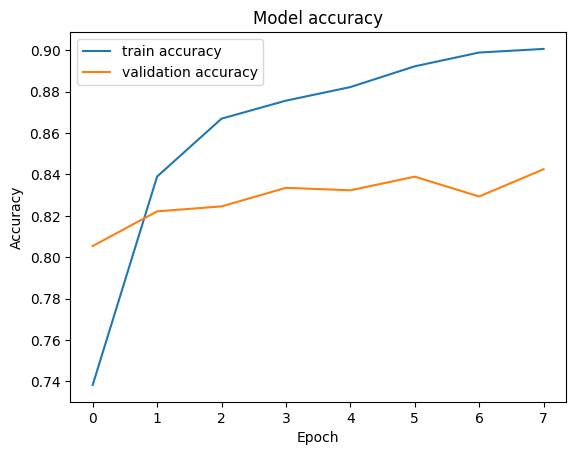

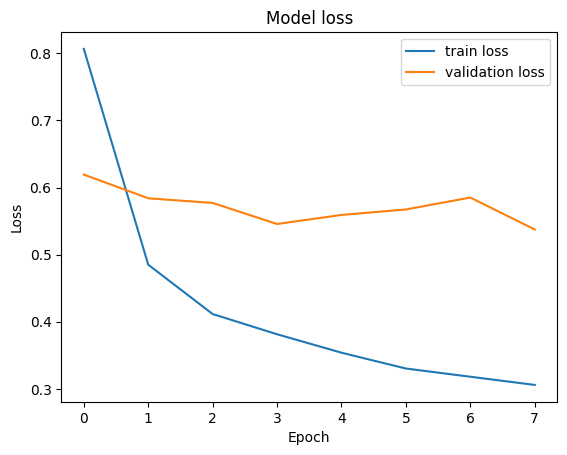

In [14]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_model_resnet50v2')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_model_resnet50v2')
    plt.show()
    
plot_accuracy(history)
plot_loss(history)

In [15]:
test_data_dir = '/content/drive/MyDrive/Bangkit/Project/Food_V2/Test'

testing_datagen = image.ImageDataGenerator(rescale=1. / 255)

testing_generator = testing_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical')

scores = model.evaluate_generator(testing_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 1670 images belonging to 9 classes.
Test Accuracy: 0.843
